In [ ]:
using QuantumAnnealingTools
using Plots
using Printf

function problem_hamiltonian()
    h = vcat(repeat([-1], 6), repeat([1], 8))
    h_idx = [1,2,3,9,11,12,5,6,7,8,13,14,15,16]
    local_term = local_field_term(h, h_idx, 16, sp=true)
    j = repeat([-1], 18)
    j_idx = [[1,5], [1,2], [1,4], [2,6], [2,3], [2,10], [4,8], [4,3], [4,12], [3,7],
        [11,10], [11,12], [11,15], [10,9], [9,12], [9,13], [10,14], [12,16]]
    two_local = two_local_term(j, j_idx, 16, sp=true)
    local_term + two_local
end

function construct_hamiltonian(E0)
    driver = E0 * real(standard_driver(16, sp=true)) / 2
    problem = E0 * real(problem_hamiltonian()) / 2
    H = SparseHamiltonian([(s)->s-1, (s)->s], [driver, problem])
    dH = (s)->driver+problem
    H, dH
end

# Model Set Up
The Hamiltonian has the form of
\begin{equation}
    H = A(s)H_d + B(s) H_p + \sum_\alpha Z_\alpha\otimes B_\alpha + H_B
\end{equation}
where $A(s)$ and $B(s)$ are the linear schedules with frequency $E_0$
\begin{equation}
    A(s) = E_0 (1-s) \quad B(s) = E_0 s \ .
\end{equation}
Additionally, $H_d$ is the standard driver Hamiltonian
\begin{equation}
    H_d = -\frac{1}{2}\sum_\alpha X_\alpha
\end{equation}
and $H_p$ is the problem Hamiltonian described in [Smirnov and Amin](https://iopscience.iop.org/article/10.1088/1367-2630/aae79c).

In [2]:
H, dH = construct_hamiltonian(3.0);
coupling = collective_coupling("Z", 16; sp=true, unit=:ħ);

# Calculate Projection
We can project this Hamiltonian into the adiabatic frame. The projection can be done with the following code:

In [6]:
# The projection will take roughly 10 mins
p_s = 0.6224
i_s = 0.6225
f_s = 0.6275
t_s = 0.6276
axis_1 = range(0.001, p_s, length=1000)
sys_1 =  project_to_lowlevel(H, dH, coupling, axis_1; tol=1e-8)
axis_2 = range(i_s, f_s, length=1000)
sys_2 = project_to_lowlevel(H, dH, coupling, axis_2; ref=sys_1.ref, tol=1e-8)
axis_3 = range(t_s, 0.999, length=1000)
sys_3 = project_to_lowlevel(H, dH, coupling, axis_3; ref=sys_2.ref, tol=0.0)
sys = concatenate(sys_1, sys_2, sys_3)

The energy structure of the problem is

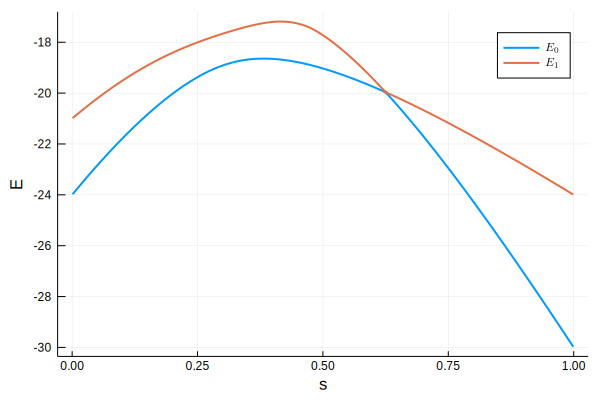

In [4]:
plot(sys.s, hcat(sys.ev...)', label=[L"E_0", L"E_1"], linewidth=2)
xlabel!("s")
ylabel!("E")

The minimum gap location is

In [64]:
v,idx = findmin([e[2]-e[1] for e in sys.ev])
@printf "The minimum gap location is s=%.4f" sys.s[idx]

The minimum gap location is s=0.6251

The geometric phase

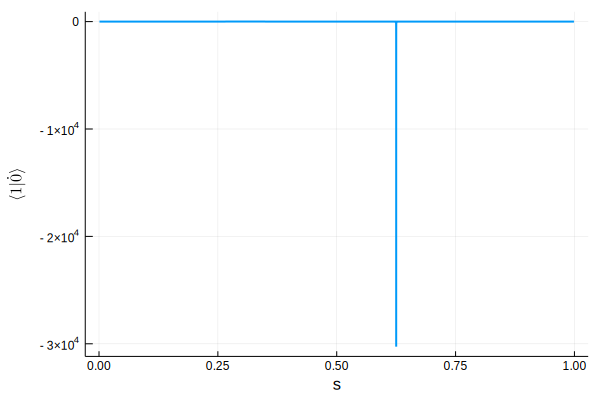

In [5]:
plot(sys.s, get_dθ(sys,2,1), label="", linewidth=2)
xlabel!("s")
ylabel!(L"\langle 1 | \dot{0} \rangle")

# Projected bath operator
In this frame, the bath can be parameterized by four parameters: $a$, $b$, $c$, $d$. They can all be constructued from the `ProjectedSystem` with the following syntax.

In [4]:
coup = construct_projected_coupling(sys);

Here we want to stree the parameter $a$
\begin{equation}
    a_{mn} = \sum_\alpha(Z_m^\alpha - Z_n^\alpha)^2
\end{equation}
where $Z_m^\alpha = \langle m |Z_\alpha | m \rangle$. This effectively measures the system bath interaction strength in the projected subspace. From the following figure, we see that both the gap $\Delta$ and $a$ goes to 0 near the anti-crossing point.

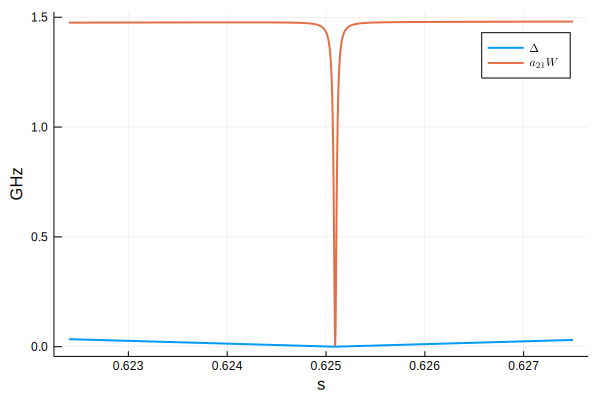

In [12]:
middle_range = 1000:2000
gap = [sys.ev[x][2]-sys.ev[x][1] for x in middle_range]
plot(sys.s[middle_range], gap, label=L"\Delta", linewidth=2)
plot!(sys.s[middle_range], 0.04 * coup.a[middle_range, 2, 1], label=L"a_{21}W", linewidth=2)
xlabel!("s")
ylabel!("GHz")

They other bath parameters are defined by
\begin{align}
    b_{mn} &= \sum_\alpha|Z^\alpha_{mn}|^2 \\
    c_{mn} &= \sum_\alpha Z^\alpha_{mn}(Z^\alpha_{m}-Z^\alpha_{n}) \\
    d_{mn} &= \sum_\alpha Z^\alpha_{mn}(Z^\alpha_{m}+Z^\alpha_{n})
\end{align}

A convinent way to plot those quantities are given below:

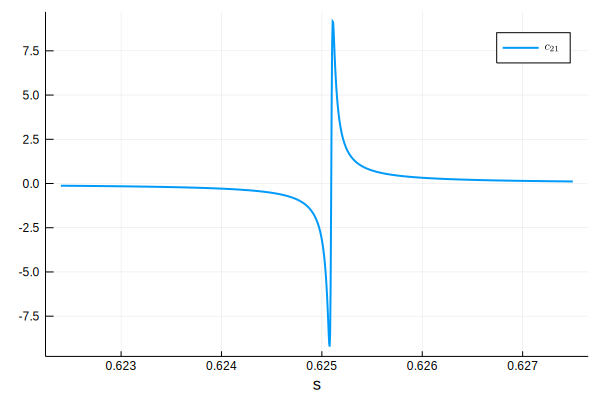

In [13]:
plot(coup, middle_range, :c, 2, 1, linewidth=2)

# Rotation

We want to find the point where $\langle1|\dot{0}\rangle=0$ and apply rotation
\begin{align}
    \lvert 0 '\rangle &= \cos\Theta \lvert 0 \rangle + \sin\Theta \lvert 1 \rangle \\
    \lvert 1 '\rangle &= -\sin\Theta \lvert 0 \rangle + \cos\Theta \lvert 1 \rangle
\end{align}
from that point.

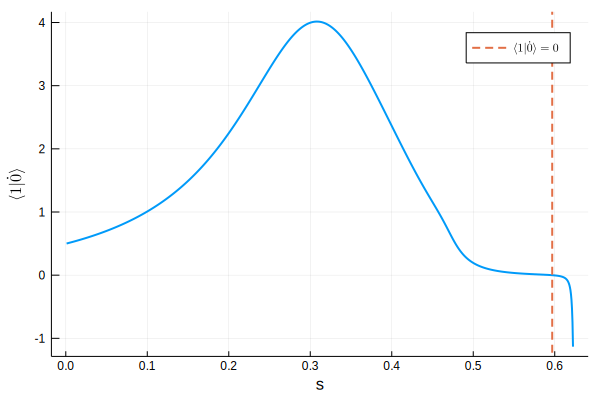

In [5]:
rotation_point = findfirst((x)->x<0, get_dθ(sys,2,1)[1:1000])
plot(sys.s[1:1000], get_dθ(sys,2,1)[1:1000], label="", linewidth=2)
vline!([sys.s[rotation_point]], label=L"\langle1|\dot{0}\rangle=0", linestyle=:dash, linewidth=2)
xlabel!("s")
ylabel!(L"\langle 1 | \dot{0} \rangle")

We plot the rotaion angle $\Theta(s)$ as a function of annealing parameter.

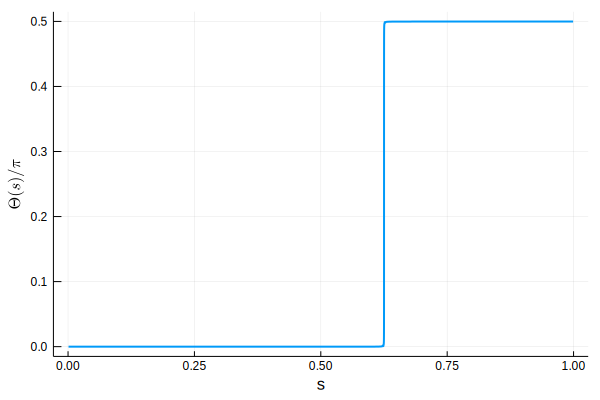

In [6]:
LZ_θ = landau_zener_rotate_angle(sys, rotation_point)
plot(sys.s, LZ_θ/π, label="", linewidth=2)
xlabel!("s")
ylabel!(L"\Theta(s) / \pi")

We apply such rotation to the system

In [7]:
rot_sys, rot_coup = landau_zener_rotate(sys::ProjectedSystem, rotation_point);

The first thing we observe is that, after the rotation, there is no "dip" of $a_{21}$ aruond the minimum gap region

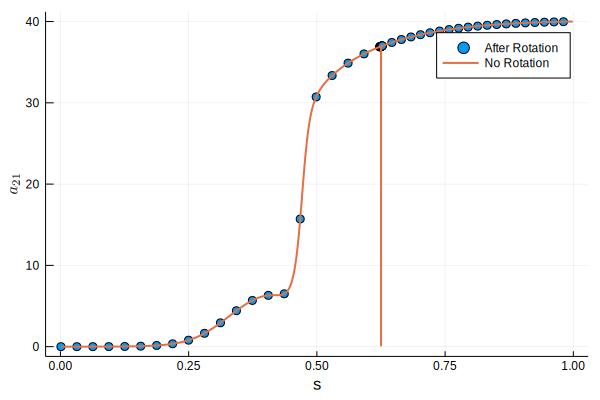

In [8]:
scatter(rot_coup, 1:50:3000, :a, 2, 1, linewidth=2, label="After Rotation")
plot!(coup, :a, 2, 1, linewidth=2, label="No Rotation")
ylabel!(L"a_{21}")

And we also suppress the geometric phase across the minimum gap

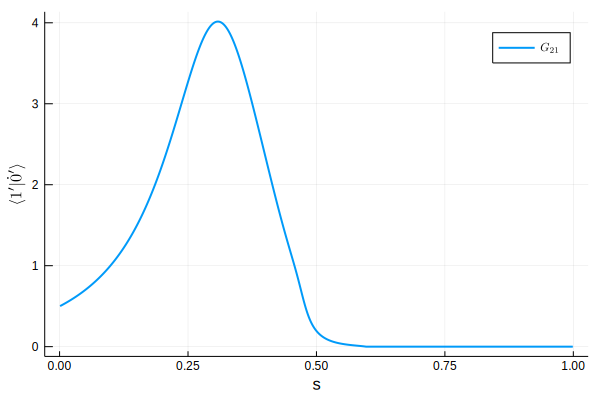

In [9]:
plot(rot_sys, :G, 2, 1, linewidth=2)
ylabel!(L"\langle 1' | \dot{0}' \rangle")

# Tunnelling matrix element and convolutional form
From the reference paper, we know the transition rate has the convolutional form
\begin{equation}
    \Gamma_{nm}(s) = \int \frac{\mathrm{d}\omega}{2\pi} \Delta_{mn}^2(\omega) G^L_{mn}(\omega_{mn}-\omega)G^H_{mn}(\omega)
\end{equation}
$G^L_{mn}(\omega)$ and $G^H_{mn}(\omega)$ are the Gaussian and Lorentzian line shape, determined by the low frequency and high frequency parts of the bath respectively. Let's first create the hybrid Ohmic bath with
## Weak low-frequency noise and strong high-frequency noise

In [10]:
W = 2
η = 0.25/2/π
fc = 8
T = 10
bath = HybridOhmic(W, η, fc, T)

Hybrid Ohmic bath instance:
W (mK): 2.0
ϵl (GHz): 0.004167322445025047
η (unitless): 0.039788735772973836
ωc (GHz): 8.0
T (mK): 10.0
ϵ (GHz): 0.32247720862881574

Next, we plot both $G^L_{21}(\omega)$ and $G^H_{21}(\omega)$ at a given time 

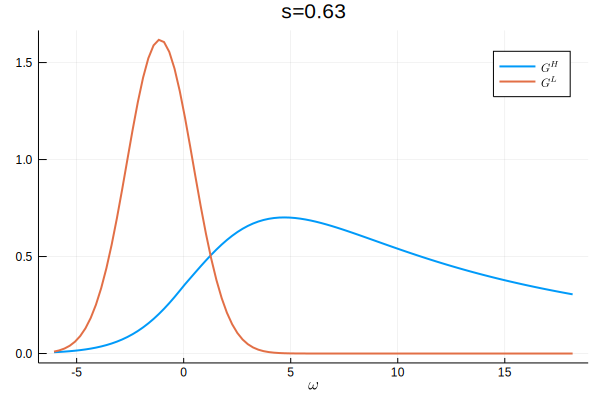

In [11]:
idx = 2000
a = rot_coup.a[idx, 2, 1]
ω = 2*π*(rot_sys.ω[idx, 2] - rot_sys.ω[idx, 1])
x_axis = range(-a*bath.width_h, 3 * a*bath.width_h, length=100)
Gh = [Gₕ(x, bath, 35.0) for x in x_axis]
Gl = [Gₗ(ω-x, bath, 35.0) for x in x_axis]
plot(x_axis, Gh, linewidth=2, label=L"G^H")
plot!(x_axis, Gl, linewidth=2, label=L"G^L")
xlabel!(L"\omega")
title!("s=" * @sprintf("%.2f",rot_sys.s[idx]))

Two limit exists for $\Gamma_{nm}(s)$ -- the Redfield limit and the Marcus limit. They correspond two the cases where $G^L_{nm}(\omega)\to\delta(\omega)/2\pi$ or $G^H_{nm}(\omega)\to\delta(\omega)/2\pi$ respectively. For our choice of bath parameters above, the hybrid rate should be close the the Redfield rate. In the following block, we plot all the these three rates.

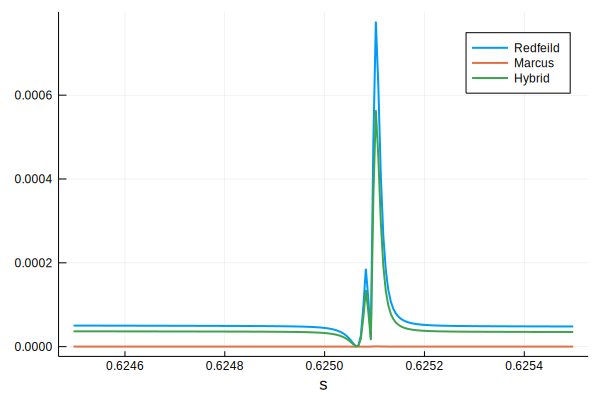

In [12]:
# here tf is the total annealing time
tf = 1000
idx = 1400:1600
redfield_Γ = [SA_redfield(x, tf, rot_sys, rot_coup, bath, 1, 2) for x in idx];
marcus_Γ = [SA_marcus(x, tf, rot_sys, rot_coup, bath, 1, 2) for x in idx];
hybrid_Γ = [SA_Γ(x, tf, rot_sys, rot_coup, bath, 1, 2)[1] for x in idx]
plot(rot_sys.s[idx], redfield_Γ, linewidth=2, label="Redfeild")
plot!(rot_sys.s[idx], marcus_Γ, linewidth=2, label="Marcus")
plot!(rot_sys.s[idx], hybrid_Γ, linewidth=2, label="Hybrid")
xlabel!("s")

### Convergence Check
Although the code is designed to run automatically, it is highly recommended to check the convergence criteria first. The convergence criteria proposed in the reference paper is
\begin{equation}
    \Gamma_{nm}\tau_{nm} \ll 1
\end{equation}
You can plot this quantity along $s$ with the following code block. We can see the convergence criteria is satisfied in this case.

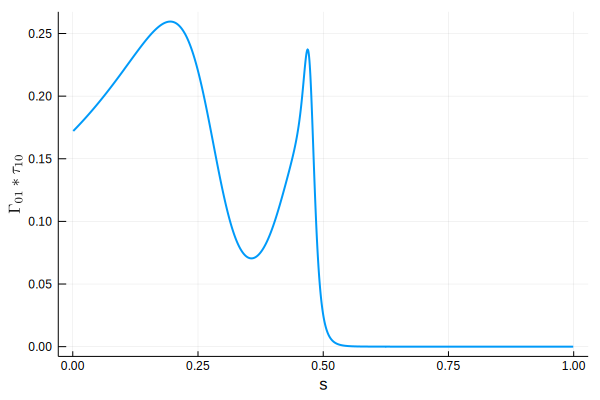

In [13]:
# here tf is the total annealing time
tf = 1000
idx = 1:length(rot_sys.s)
hybrid_Γ = [SA_Γ(x, tf, rot_sys, rot_coup, bath, 1, 2)[1] for x in idx]
# the index of SA_τ is aligned with hybrid_Γ
τ = [SA_τ(x, tf, rot_sys, rot_coup, bath, 1, 2) for x in idx]
plot(rot_sys.s[idx], hybrid_Γ .* τ, linewidth=2, label="")
xlabel!("s")
ylabel!(L"\Gamma_{01}*\tau_{10}")

### Solve the ME
We can solve the equation of motion defined by rates $\Gamma_{nm}(s)$
\begin{equation}
    \dot{\vec{P}} = t_f \Gamma \vec{P}
\end{equation}
with a single function.

PS: Currently this function does not implement many advanced features you can find in other solvers of this package. It is recommended to you manually check the rates and convergence criteria before using this function.

In [17]:
tf = 1000
u0 = [1.0, 0.0]
sol = solve_SA(rot_sys, rot_coup, bath, [1.0, 0.0], tf; alg = Tsit5(), tstops = [0.6251], reltol=1e-7, abstol=1e-7);

We can also rotate the system back to the adiabatic frame and plot the instantaneous eigenstate popuplation.

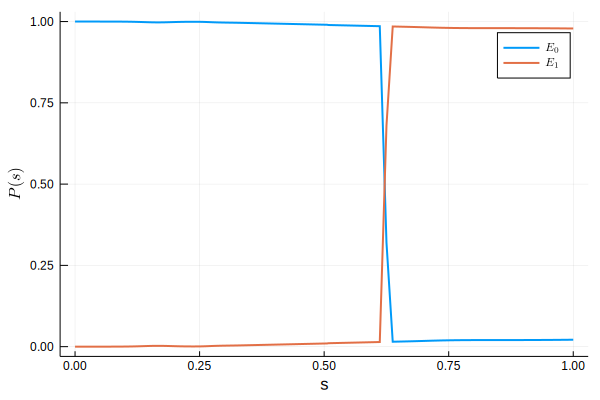

In [20]:
θ_itp = construct_interpolations(sys.s, LZ_θ)
pop = SA_lz_rotate(sol, θ_itp, [1,2])
plot(sol.t, pop, linewidth=2, label=[L"E_0", L"E_1"])
xlabel!("s")
ylabel!(L"P(s)")

## Strong low_frequency noise and weak high-frequency noise

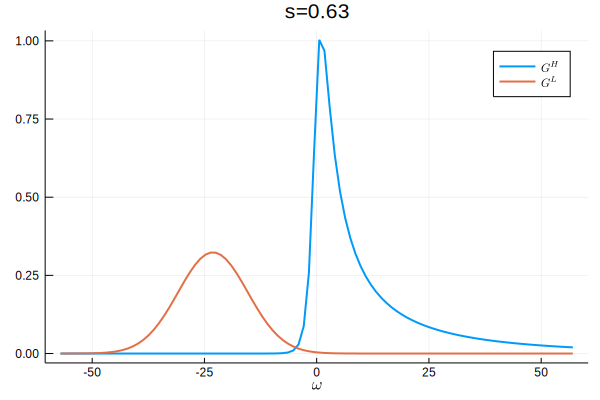

In [25]:
W = 10
η = 0.1/2/π
fc = 8
T = 10
bath = HybridOhmic(W, η, fc, T)

idx = 2000
a = rot_coup.a[idx, 2, 1]
ω = 2*π*(rot_sys.ω[idx, 2] - rot_sys.ω[idx, 1])
x_axis = range(-a*bath.width_l, a*bath.width_l, length=100)
Gh = [Gₕ(x, bath, 35.0) for x in x_axis]
Gl = [Gₗ(ω-x, bath, 35.0) for x in x_axis]
plot(x_axis, Gh, linewidth=2, label=L"G^H")
plot!(x_axis, Gl, linewidth=2, label=L"G^L")
xlabel!(L"\omega")
title!("s=" * @sprintf("%.2f",rot_sys.s[idx]))

In this limit, we expect the hybrid noise to be close to the Marcus limit

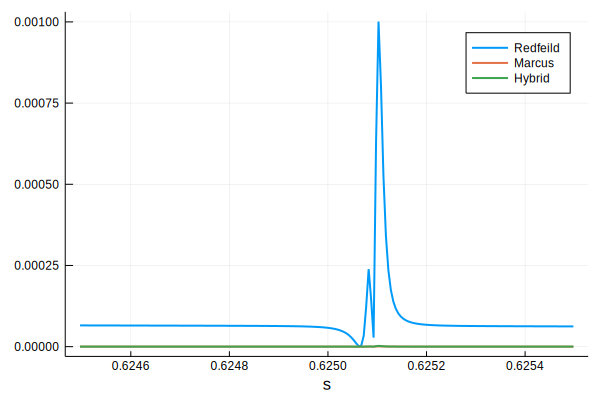

In [26]:
idx = 1400:1600
redfield_Γ = [SA_redfield(x, 1000, rot_sys, rot_coup, bath, 1, 2) for x in idx];
marcus_Γ = [SA_marcus(x, 1000, rot_sys, rot_coup, bath, 1, 2) for x in idx];
hybrid_Γ = [SA_Γ(x, 1000, rot_sys, rot_coup, bath, 1, 2)[1] for x in idx]
plot(rot_sys.s[idx], redfield_Γ, linewidth=2, label="Redfeild")
plot!(rot_sys.s[idx], marcus_Γ, linewidth=2, label="Marcus")
plot!(rot_sys.s[idx], hybrid_Γ, linewidth=2, label="Hybrid")
xlabel!("s")

Since it is hard to see, we can plot only the Marcus rate and the hybrid rate.

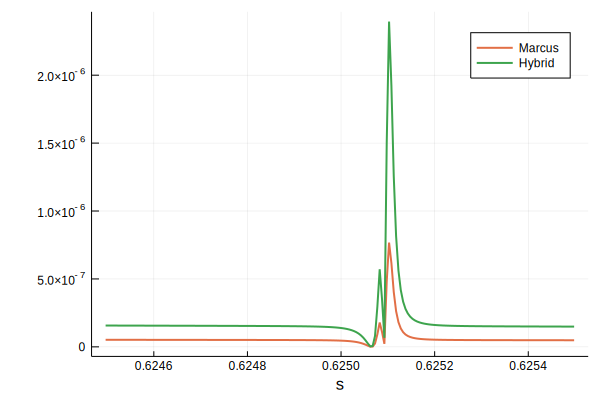

In [23]:
plot(rot_sys.s[idx], marcus_Γ, linewidth=2, label="Marcus", color=2)
plot!(rot_sys.s[idx], hybrid_Γ, linewidth=2, label="Hybrid", color=3)
xlabel!("s")

### Convergence Check
As for the frist case, we manually do the convergence check first.

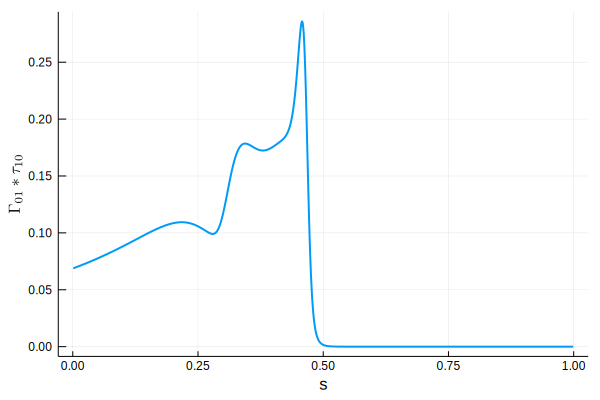

In [35]:
idx = 1:length(rot_sys.s)
hybrid_Γ = [SA_Γ(x, 1000, rot_sys, rot_coup, bath, 1, 2)[1] for x in idx]
τ = [SA_τ(x, 1000, rot_sys, rot_coup, bath, 1, 2) for x in idx]
plot(rot_sys.s[idx], hybrid_Γ .* τ, linewidth=2, label="")
xlabel!("s")
ylabel!(L"\Gamma_{01}*\tau_{10}")

### Solve the ME
As for the first case, we can also solve the ME and plot the instantaneous eigenstate populations.

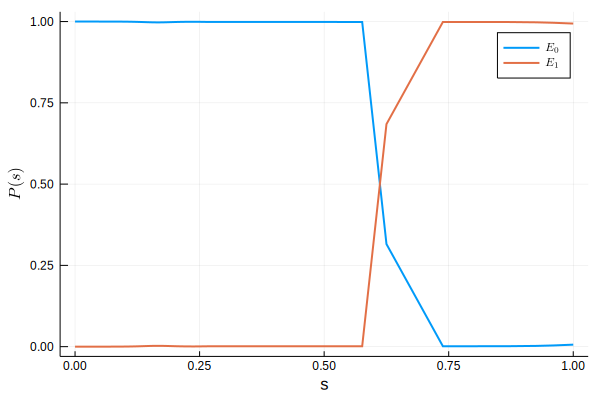

In [24]:
tf = 1000
u0 = [1.0, 0.0]
sol = solve_SA(rot_sys, rot_coup, bath, [1.0, 0.0], tf; alg = Tsit5(), tstops = [0.6251], reltol=1e-7, abstol=1e-7);
θ_itp = construct_interpolations(sys.s, LZ_θ)
pop = SA_lz_rotate(sol, θ_itp, [1,2])
plot(sol.t, pop, linewidth=2, label=[L"E_0", L"E_1"])
xlabel!("s")
ylabel!(L"P(s)")